<h2 style='color:blue' align='center'>Sports Celebrity Image Classification<h2>




In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

<h3 style='color:purple'>Step 1-a- Image Preprocessing: Detect face and eyes</h3>

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>

In [8]:

img = cv2.imread('C:\\Users\\Saurabh\\Lm.jpg')


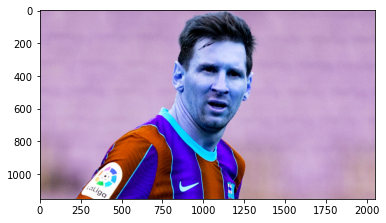

In [7]:
## Visualizing the image
plt.imshow(img)


In [9]:
## converting image into gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1152, 2048)

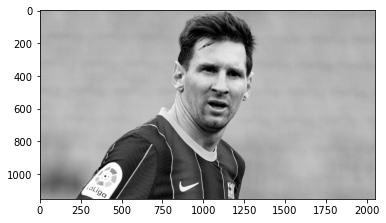

In [10]:
plt.imshow(gray, cmap='gray')

In [ ]:
face_cascade=cv2.CascadeClassifier('C:\\Code\Sports_person_Classifier\model\opncv\haarcascades\haarcascade_frontalface.xml')
eye_cascade=cv2.CascadeClassifier('C:\\Code\Sports_person_Classifier\model\opencv\haarcascades\haarcascade_eye.xml')



In [12]:
## Our classifier returns the region of intrest(ROI) of the detected face as a tuple
## It stores the top left coordinate and the bottom right coordiantes
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
(x,y,w,h) = faces[0]
x,y,w,h

(884, 199, 448, 448)

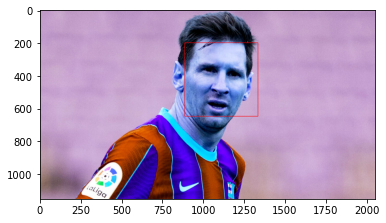

In [13]:
## making a rectangle on the ROI
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

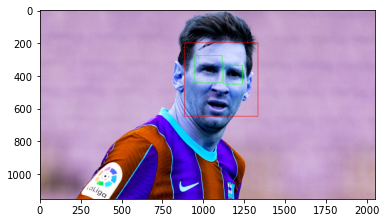

In [14]:
## It helps to clear all the extra screen
cv2.destroyAllWindows()

## We iterate through our faces array and draw a rectangle
## over each face and eyes
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

For making the classifier we need the face, so we take the rectangle drawn to the face

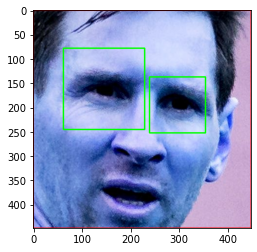

In [15]:
## Visualing the roi of face
plt.imshow(roi_color, cmap='gray')

In [16]:
#cropped_img = np.array(roi_color)
#ropped_img.shape

Defining a function which loads the image and detect face. If eyes >=2, then save and crop the face region

In [17]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

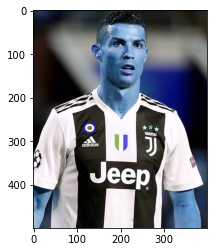

In [20]:
## Checking the working of function
original_image = cv2.imread('C:\\Users\\Saurabh\\dataset\\ronaldo\\Cristiano Ronaldo.jpg')
plt.imshow(original_image)

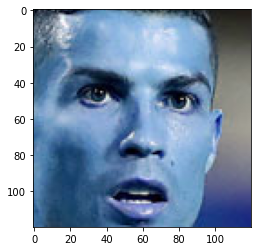

In [21]:
## Calling the function to apply on the image
path='C:\\Users\\Saurabh\\dataset\\ronaldo\\Cristiano Ronaldo.jpg'
cropped_img = get_cropped_image_if_2_eyes(path)
plt.imshow(cropped_img)

In [30]:
## specifying path to the current directory

path_to_data = ".\\dataset\\"
path_to_cr_data = ".\\dataset\\cropped\\"

In [31]:
import os
os.getcwd()

'C:\\Users\\Saurabh'

In [32]:
## going in the directory of data and making a list of folders
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [33]:
img_dirs

['.\\dataset\\pv_sindhu',
 '.\\dataset\\roger_federer',
 '.\\dataset\\ronaldo',
 '.\\dataset\\sunil_chhetri',
 '.\\dataset\\virat_kohli']

Going through all images in dataset folder and created cropped images for them.
The cropped images would be stored in the folder named cropped inside the same directory

In [ ]:
## initializing a list for cropped images directory
cropped_image_dirs = []

## Initializing a tuple for each class of celebrity
celebrity_file_names_dict = {}

for img_dir in img_dirs: ## iterating through every path of the image
    count = 1
    celebrity_name = img_dir.split('/')[-1]  ## spliting the string in inorder to extract class name 
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):  ## to go through every picture in the path
        roi_color = get_cropped_image_if_2_eyes(entry.path)  ## Applying the cropped image function 
        if roi_color is not None:  ## If the image has proper face and eyes
            cropped_folder = path_to_cr_data + celebrity_name    ## Store value in cropped folder with classes assigned
            if not os.path.exists(cropped_folder):     ## If cropped folder does not exist,create the crop folder
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)  ## appendind the path of the cropped image directory  
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + "%d" + str(count) + ".png"  ## naming each picture 
            cropped_file_path = cropped_folder + "/" + cropped_file_name  
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

In [ ]:
celebrity_file_names_dict.keys()

Now we have cropped folder under datasets folder that contains cropped images
Next step is to manually examine cropped folder and delete any unwanted images

###Step 2-Feature extraction

#### In **wavelet transformed** image, we can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc. We can see a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

In [57]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H



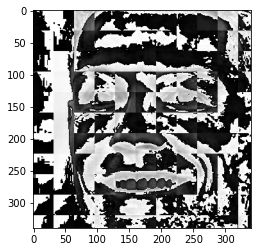

In [58]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Creating a dictonary for Y values

In [59]:
## Creating a dictonary to store the class label with keys
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'pv_sindhu': 0,
 'roger_federer': 1,
 'ronaldo': 3,
 'sunil_chhetri': 2,
 'virat_kohli': 4}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [60]:
## Collecting Data for dependent and independet variable
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
          continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [67]:
## Reshaping the X feature
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(432, 4096)

### Data cleaning process is done. Now we are ready to train our model

We will use SVM with rbf kernel tuned  with heuristic finetuning

In [68]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [69]:
## Train_test split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.20, random_state=0)

##Using pipeline to feature scale and applying SVM classifier
pipe = Pipeline([('min_max_scaler', MinMaxScaler()), ('svc', SVC(kernel = 'linear', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9080459770114943

In [70]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       1.00      1.00      1.00         6
           2       0.90      0.86      0.88        22
           3       0.90      0.90      0.90        20
           4       0.86      0.90      0.88        20

    accuracy                           0.91        87
   macro avg       0.92      0.92      0.92        87
weighted avg       0.91      0.91      0.91        87



### Using GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [71]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [72]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [74]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(MinMaxScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.860870,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.739130,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.872464,{'logisticregression__C': 1}


In [75]:
best_estimators

{'logistic_regression': Pipeline(memory=None,
          steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                 ('logisticregression',
                  LogisticRegression(C=1, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='liblinear', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), 'random_forest': Pipeline(memory=None,
          steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gin

In [76]:
best_estimators['svm'].score(X_test,y_test)

0.8735632183908046

In [77]:
best_estimators['random_forest'].score(X_test,y_test)

0.8505747126436781

In [78]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.896551724137931

In [79]:
best_clf = best_estimators['logistic_regression']

### Save the trained model

In [83]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))